In [1]:
#default_exp covid

# Covid

<br>

### Imports

In [1]:
#exports
import json
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from skopt.plots import plot_objective
from skopt.space import Real, Categorical, Integer

from batopt import clean, discharge, charge, pv, utils, tuning

import os
from ipypb import track

In [2]:
import FEAutils as hlp
import matplotlib.pyplot as plt

from IPython.display import JSON

<br>

### User Inputs

In [3]:
intermediate_data_dir = '../data/intermediate'
raw_data_dir = '../data/raw'
cache_data_dir = '../data/nb-cache'

<br>

### Preparing Data

First we'll load in the target and feature data for both the charging and discharging models, setting `covid=True`

In [19]:
COVID=True
covid_start_date = '2020-03-26'
df = clean.combine_training_datasets(intermediate_data_dir).interpolate(limit=1)
s_demand = clean.load_training_dataset(intermediate_data_dir, 'demand')['demand_MW']
charge_x, charge_y = charge.prepare_training_input_data(intermediate_data_dir)
discharge_x, discharge_y = discharge.prepare_training_input_data(intermediate_data_dir, covid=COVID)



charge_x.head()

2017-11-10 00:00:00+00:00    0.0
2017-11-10 00:30:00+00:00    0.0
2017-11-10 01:00:00+00:00    0.0
2017-11-10 01:30:00+00:00    0.0
2017-11-10 02:00:00+00:00    0.0
                            ... 
2020-07-02 21:30:00+00:00    0.0
2020-07-02 22:00:00+00:00    0.0
2020-07-02 22:30:00+00:00    0.0
2020-07-02 23:00:00+00:00    0.0
2020-07-02 23:30:00+00:00    0.0
Freq: 30T, Name: pv_power_mw, Length: 46368, dtype: float64


,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6,pv_7d_lag,solar_location2,solar_location3,solar_location5,...,solar_location2_rolling,solar_location3_rolling,solar_location5_rolling,solar_location6_rolling,temp_location1_rolling,temp_location2_rolling,temp_location3_rolling,temp_location4_rolling,temp_location5_rolling,temp_location6_rolling
2017-11-10 04:00:00+00:00,11.930,11.71,11.730,11.300,13.15,13.220,0.0,0.0,0.0,0.0,...,0.0,0.0,1.894781e-13,3.315866e-13,11.805000,11.56,11.600000,10.650000,13.085000,13.215000
2017-11-10 04:30:00+00:00,12.060,11.89,11.805,11.295,13.26,13.325,0.0,0.0,0.0,0.0,...,0.0,0.0,1.894781e-13,3.315866e-13,11.931667,11.72,11.711667,11.081667,13.165000,13.253333
2017-11-10 05:00:00+00:00,12.190,12.07,11.880,11.290,13.37,13.430,0.0,0.0,0.0,0.0,...,0.0,0.0,1.894781e-13,3.315866e-13,12.060000,11.89,11.805000,11.295000,13.260000,13.325000
2017-11-10 05:30:00+00:00,12.145,12.13,11.745,11.200,13.44,13.520,0.0,0.0,0.0,0.0,...,0.0,0.0,1.894781e-13,3.315866e-13,12.131667,12.03,11.810000,11.261667,13.356667,13.425000
2017-11-10 06:00:00+00:00,12.100,12.19,11.610,11.110,13.51,13.610,0.0,0.0,0.0,0.0,...,0.0,0.0,1.894781e-13,3.315866e-13,12.145000,12.13,11.745000,11.200000,13.440000,13.520000


4
5
6


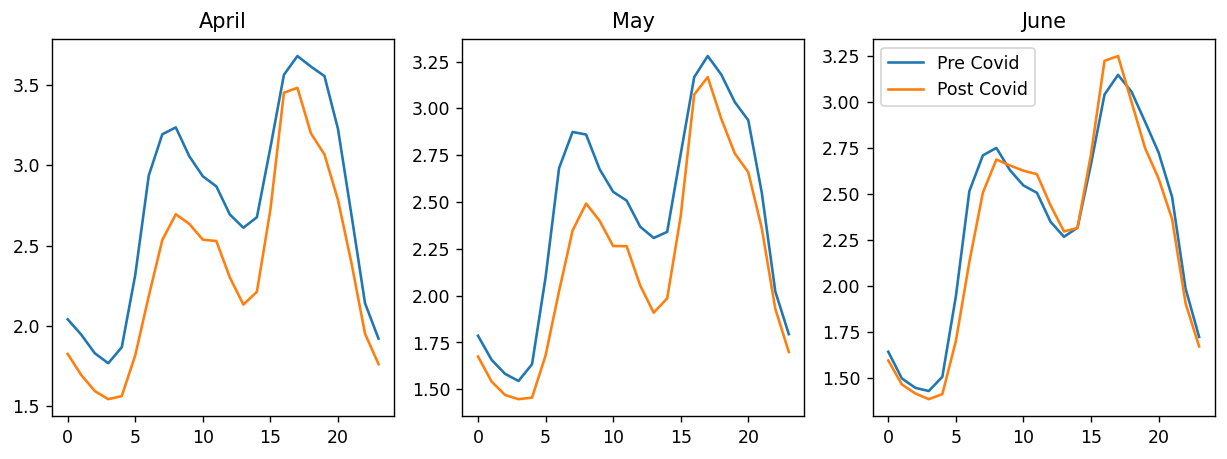

In [41]:

pre_covid = df[df.index.date < pd.to_datetime(covid_start_date)]
post_covid = df[df.index.date >= pd.to_datetime(covid_start_date)]

end_date = post_covid.index.date[-1]

fig, axs =plt.subplots(1,3, figsize=(12,4), dpi=125)

for i, month, month_name in zip([0,1,2], [4,5,6], ['April', 'May', 'June']):
    
    print(month)

    pre_covid_month = pre_covid[pre_covid.index.month==month]
    pre_covid_month_mean = pre_covid_month.groupby(pre_covid_month.index.hour).mean()['demand_MW']

    post_covid_month = post_covid[post_covid.index.month==month]
    post_covid_month_mean = post_covid_month.groupby(post_covid_month.index.hour).mean()['demand_MW']


    axs[i].plot(pre_covid_month_mean, label="Pre Covid")
    axs[i].plot(post_covid_month_mean, label="Post Covid")
    axs[i].set_title(month_name)

plt.legend()
plt.show()

### Comparison with and without the covid features

COVID Features: False, Use COVID Data: False
K-fold MSE: 0.01347, mean peak reduction: 49.253


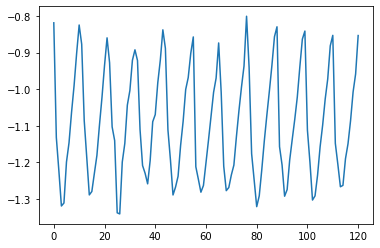

Held out mean peak reduction: 60.79157966526768

COVID Features: False, Use COVID Data: True
K-fold MSE: 0.01384, mean peak reduction: 50.388


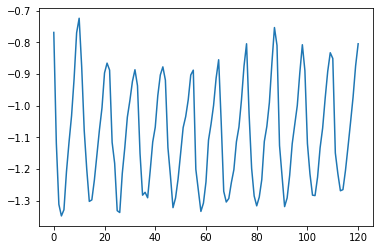

Held out mean peak reduction: 61.65862535691542

COVID Features: True, Use COVID Data: True
K-fold MSE: 0.01346, mean peak reduction: 50.512


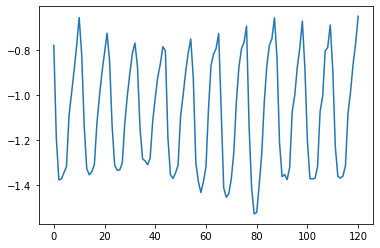

Held out mean peak reduction: 62.148786827250426



In [49]:
start_of_test_period = '2020-06-22'
discharge_model = RandomForestRegressor()
rerun = False

s_demand = clean.load_training_dataset(intermediate_data_dir, 'demand')['demand_MW']

discharge_x, discharge_y = discharge.prepare_training_input_data(intermediate_data_dir, covid=True)

if rerun:
    for COVID_FEATURES in [False, True]: # Use the variables relating to covid: should have `covid` in the name
        for USE_COVID_DATA in [False, True]: # Whether to completely omit the data from the covid period... 

            if COVID_FEATURES and not USE_COVID_DATA:
                continue

            discharge_x_train, discharge_x_test = tuning.get_train_test(discharge_x, start_of_test_period)
            discharge_y_train, discharge_y_test = tuning.get_train_test(discharge_y, start_of_test_period)

            if not COVID_FEATURES:
                covid_cols = [c for c in discharge_x_train.columns if 'covid' in c]
                discharge_x_train = discharge_x_train.drop(covid_cols, axis=1)
                discharge_x_test = discharge_x_test.drop(covid_cols, axis=1)

            if USE_COVID_DATA is False:
                discharge_x_train = discharge_x_train[discharge_x_train.index.date < pd.to_datetime(covid_start_date)]
                discharge_y_train = discharge_y_train[discharge_y_train.index.date < pd.to_datetime(covid_start_date)]

            # K-fold predictions
            df_pred = clean.generate_kfold_preds(discharge_x_train.values, discharge_y_train.values, model=discharge_model)
            df_pred['diff'] = df_pred.true - df_pred.pred
            df_pred.index = discharge_x_train.index
            mse = np.mean(np.square(df_pred['diff']))

            s_pct_peak_reduction = tuning.calculate_pct_peak_reduction_s(df_pred.pred, s_demand)
            mean_peak_reduction = s_pct_peak_reduction.mean()

            print("COVID Features: {}, Use COVID Data: {}".format(COVID_FEATURES, USE_COVID_DATA))
            print("K-fold MSE: {:.5f}, mean peak reduction: {:.3f}".format(mse, mean_peak_reduction))

            # Held out version
            discharge_model.fit(discharge_x_train, discharge_y_train)
            discharge_y_pred = pd.Series(discharge_model.predict(discharge_x_test), index=discharge_x_test.index)
            s_pct_peak_reduction = tuning.calculate_pct_peak_reduction_s(discharge_y_pred, s_demand)
            mean_peak_reduction = s_pct_peak_reduction.mean()

            plt.plot(discharge_y_pred.values)
            plt.show()

            print("Held out mean peak reduction: {}".format(mean_peak_reduction))
            print()
    
    

In [ ]:
discharge_rf = RandomForestRegressor()

discharge_rf.fit(discharge_x_train, discharge_y_train)
discharge_y_pred = pd.Series(discharge_rf.predict(discharge_x_test), index=discharge_x_test.index)

discharge_y_pred.plot()

<br>

Finally we'll export the relevant code to our `batopt` module

In [33]:
#hide
from nbdev.export import notebook2script
    
notebook2script()

Converted 00-utilities.ipynb.
Converted 01-retrieval.ipynb.
Converted 02-cleaning.ipynb.
Converted 03-charging.ipynb.
Converted 04-discharging.ipynb.
Converted 05-constraints.ipynb.
Converted 06-tuning.ipynb.
Converted 07-charging-nn.ipynb.
Converted 08-pv-forecast.ipynb.
Converted 09-christmas.ipynb.
Converted 09-pipeline.ipynb.
Converted 10-pipeline.ipynb.
Converted 11-covid.ipynb.
Converted Untitled.ipynb.
